In [1]:
#-------------------------------
# Step 0. Setting up the imports
#-------------------------------
import numpy as np

# Qiskit from IBM
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Define backends
use_real = True

if use_real:
    backend = service.backend('ibmq_kolkata')
else:
    backend = service.backend('ibmq_qasm_simulator')

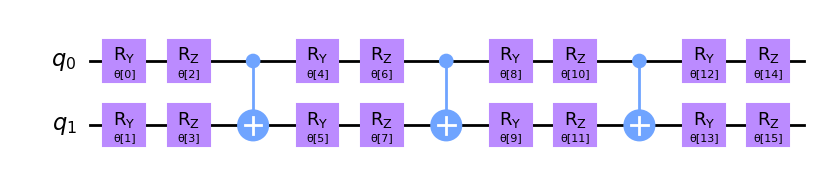

In [2]:
#---------------------------
# Step 1. circuit selection 
#---------------------------

# Qiskit circuit library
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(2)

ansatz.decompose().draw('mpl')

In [3]:
#------------------------------
# Step 2. Problem specification
#------------------------------
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([('YZ', 0.39793742484318045),
                                     ('ZI', -0.39793742484318045),
                                     ('ZZ', -0.01128010425623538),
                                     ('XX', 0.18093119978423156)])

print (hamiltonian)

SparsePauliOp(['YZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[ 0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,  0.1809312 +0.j])


In [ ]:
#------------------------------------
# Step 3. Execute using the Estimator
#------------------------------------

# Import SPSA from module until SPSA is part of scipy
from spsa import minimize_spsa
#from scipy.optimize import minimize

def cost_func(params, ansatz, hamiltonian, estimator):
        """Return estimate of energy from estimator

        Parameters:
            params (ndarray): Array of ansatz parameters
            ansatz (QuantumCircuit): Parameterized ansatz circuit
            hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
            estimator (Estimator): Estimator primitive instance

        Returns:
            float: Energy estimate
        """
        energy = estimator.run(ansatz, hamiltonian,
                               parameter_values=params).result().values[0]
        return energy


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = estimator.run(ansatz, hamiltonian,
                                     parameter_values=current_vector).result().values[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

num_params = ansatz.num_parameters
params = 2*np.pi*np.random.random(num_params)

options = Options(optimization_level=1)
options.execution.shots = 5000  # Options can be set using auto-complete.

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    #res = minimize(cost_func, x0=params,
    #               args=(ansatz, hamiltonian, estimator),
    #               callback=callback,
    #               maxiter=100, method='coblya')
    res = minimize_spsa(cost_func, x0=params,
                        args=(ansatz, hamiltonian, estimator),
                        callback=callback,
                        maxiter=100)

In [ ]:
print(res)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(callback_dict['cost_history'], lw=2)
plt.axhline(y=np.linalg.eigvalsh(hamiltonian.to_matrix())[0], color='r', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.show()